# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from dl4cv.classifiers.fc_net import *
from dl4cv.data_utils import get_CIFAR10_data
from dl4cv.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dl4cv.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (48000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (48000,)
y_test:  (1000,)


# Affine layer: foward
Open the file `dl4cv/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print 'Testing affine_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing affine_forward function:
difference:  9.76984946819e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print 'Testing affine_backward function:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_backward function:
dx error:  1.16484329865e-09
dw error:  7.91910652354e-11
db error:  1.31045337829e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print 'Testing relu_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print 'Testing relu_backward function:'
print 'dx error: ', rel_error(dx_num, dx)

Testing relu_backward function:
dx error:  3.27564636688e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `dl4cv/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from dl4cv.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print 'Testing affine_relu_forward:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_relu_forward:
dx error:  1.30014244731e-10
dw error:  2.54428608868e-10
db error:  3.9507519178e-11


# Loss layers: Softmax
You implemented this loss function in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `dl4cv/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print '\nTesting softmax_loss:'
print 'loss: ', loss
print 'dx error: ', rel_error(dx_num, dx)


Testing softmax_loss:
loss:  2.30251682529
dx error:  8.56436303777e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `dl4cv/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print 'Testing initialization ... '
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print 'Testing test-time forward pass ... '
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print 'Testing training loss (no regularization)'
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print 'Running numeric gradient check with reg = ', reg
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0


W1 relative error: 1.83e-08


W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7


W1 relative error: 2.53e-07


W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `dl4cv/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
reg = 0.19
hidden_dim = 100

num_epochs=10
lr_decay=0.95
batch_size=300
print_every=100
optim_config={'learning_rate': 0.00123456, }

model = TwoLayerNet(hidden_dim=hidden_dim)
solver = Solver(model,
                data,
                num_epochs=num_epochs,
                lr_decay=lr_decay,
                batch_size=batch_size,
                print_every=print_every,
                optim_config=optim_config)

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
#pass
solver.train()

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1600) loss: 2.303025
(Epoch 0 / 10) train acc: 0.135000; val_acc: 0.127000


KeyboardInterrupt: 

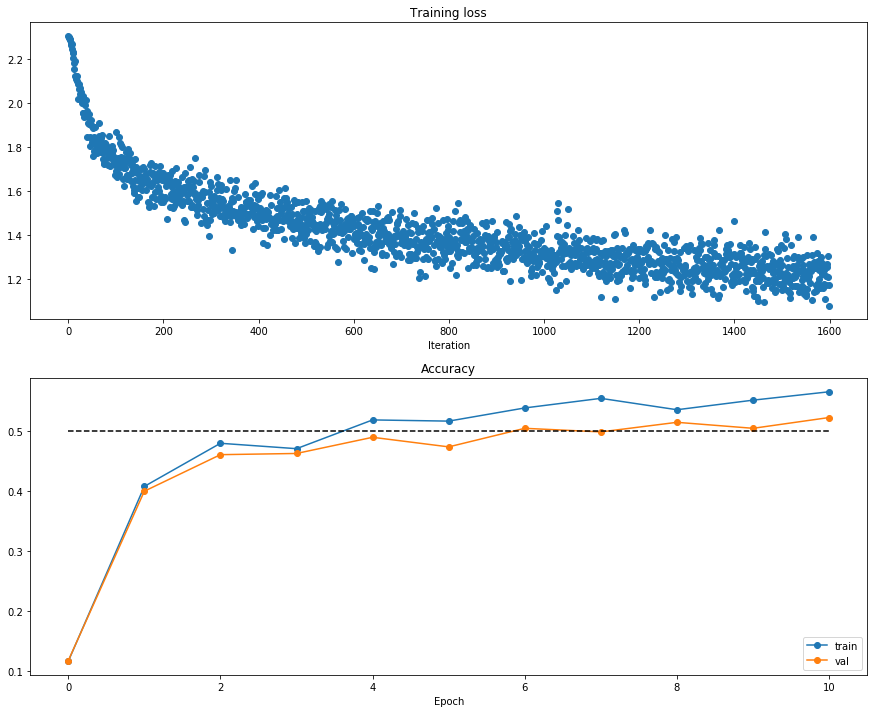

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `dl4cv/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing batch normalization.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [ ]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print 'Running check with reg = ', reg
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Running check with reg =  0
('Shape of ', 'W1', ' is ', (15, 20))
('Shape of ', 'b1', ' is ', (20,))
('Shape of ', 'W2', ' is ', (20, 30))
('Shape of ', 'b2', ' is ', (30,))
('Shape of ', 'W3', ' is ', (30, 10))
('Shape of ', 'b3', ' is ', (10,))
Initial loss:  2.3047456169


W1 relative error: 5.57e-08


W2 relative error: 2.92e-07


W3 relative error: 1.61e-07
b1 relative error: 5.61e-09
b2 relative error: 3.51e-09
b3 relative error: 1.34e-10
Running check with reg =  3.14
('Shape of ', 'W1', ' is ', (15, 20))
('Shape of ', 'b1', ' is ', (20,))
('Shape of ', 'W2', ' is ', (20, 30))
('Shape of ', 'b2', ' is ', (30,))
('Shape of ', 'W3', ' is ', (30, 10))
('Shape of ', 'b3', ' is ', (10,))
Initial loss:  7.07667107767


W1 relative error: 8.73e-08


W2 relative error: 2.54e-08


W3 relative error: 9.79e-08
b1 relative error: 9.46e-09
b2 relative error: 4.34e-09
b3 relative error: 1.93e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

('Shape of ', 'W1', ' is ', (3072, 100))
('Shape of ', 'b1', ' is ', (100,))
('Shape of ', 'W2', ' is ', (100, 100))
('Shape of ', 'b2', ' is ', (100,))
('Shape of ', 'W3', ' is ', (100, 10))
('Shape of ', 'b3', ' is ', (10,))
(Iteration 1 / 40) loss: 2.290338


(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.096000
(Epoch 1 / 20) train acc: 0.400000; val_acc: 0.133000


(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.134000


(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.158000
(Epoch 4 / 20) train acc: 0.580000; val_acc: 0.135000


(Epoch 5 / 20) train acc: 0.660000; val_acc: 0.134000
(Iteration 11 / 40) loss: 1.866154
(Epoch 6 / 20) train acc: 0.600000; val_acc: 0.140000


(Epoch 7 / 20) train acc: 0.720000; val_acc: 0.136000
(Epoch 8 / 20) train acc: 0.620000; val_acc: 0.135000


(Epoch 9 / 20) train acc: 0.660000; val_acc: 0.142000
(Epoch 10 / 20) train acc: 0.900000; val_acc: 0.156000
(Iteration 21 / 40) loss: 0.890118


(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.169000
(Epoch 12 / 20) train acc: 0.920000; val_acc: 0.163000


(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.165000


(Epoch 14 / 20) train acc: 0.860000; val_acc: 0.152000


(Epoch 15 / 20) train acc: 0.940000; val_acc: 0.168000
(Iteration 31 / 40) loss: 0.198155
(Epoch 16 / 20) train acc: 0.980000; val_acc: 0.168000


(Epoch 17 / 20) train acc: 0.980000; val_acc: 0.170000
(Epoch 18 / 20) train acc: 0.980000; val_acc: 0.165000


(Epoch 19 / 20) train acc: 1.000000; val_acc: 0.166000
(Epoch 20 / 20) train acc: 1.000000; val_acc: 0.163000


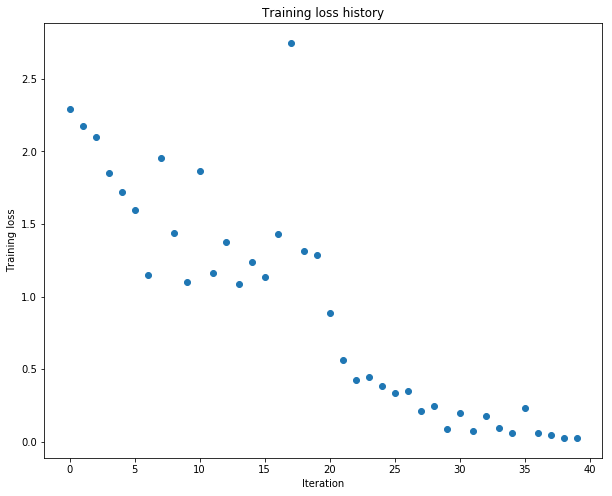

In [ ]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

('Shape of ', 'W1', ' is ', (3072, 100))
('Shape of ', 'b1', ' is ', (100,))
('Shape of ', 'W2', ' is ', (100, 100))
('Shape of ', 'b2', ' is ', (100,))
('Shape of ', 'W3', ' is ', (100, 100))
('Shape of ', 'b3', ' is ', (100,))
('Shape of ', 'W4', ' is ', (100, 100))
('Shape of ', 'b4', ' is ', (100,))
('Shape of ', 'W5', ' is ', (100, 10))
('Shape of ', 'b5', ' is ', (10,))
(Iteration 1 / 40) loss: 2.471646
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.093000
(Iteration 2 / 40) loss: 11.071012


(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.094000
(Iteration 3 / 40) loss: 2.613681
(Iteration 4 / 40) loss: 2.538409
(Epoch 2 / 20) train acc: 0.180000; val_acc: 0.094000
(Iteration 5 / 40) loss: 2.044222
(Iteration 6 / 40) loss: 2.087946


(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.094000
(Iteration 7 / 40) loss: 2.138650
(Iteration 8 / 40) loss: 1.751077


(Epoch 4 / 20) train acc: 0.180000; val_acc: 0.099000
(Iteration 9 / 40) loss: 2.134135
(Iteration 10 / 40) loss: 2.106000
(Epoch 5 / 20) train acc: 0.440000; val_acc: 0.086000
(Iteration 11 / 40) loss: 1.942169
(Iteration 12 / 40) loss: 1.589202


(Epoch 6 / 20) train acc: 0.380000; val_acc: 0.123000
(Iteration 13 / 40) loss: 2.279489
(Iteration 14 / 40) loss: 1.619025
(Epoch 7 / 20) train acc: 0.500000; val_acc: 0.145000
(Iteration 15 / 40) loss: 1.492433
(Iteration 16 / 40) loss: 1.421792


(Epoch 8 / 20) train acc: 0.560000; val_acc: 0.149000
(Iteration 17 / 40) loss: 1.190442
(Iteration 18 / 40) loss: 2.367167


(Epoch 9 / 20) train acc: 0.200000; val_acc: 0.110000
(Iteration 19 / 40) loss: 2.646220
(Iteration 20 / 40) loss: 1.571275


(Epoch 10 / 20) train acc: 0.360000; val_acc: 0.112000
(Iteration 21 / 40) loss: 1.908351
(Iteration 22 / 40) loss: 1.793713
(Epoch 11 / 20) train acc: 0.640000; val_acc: 0.158000


(Iteration 23 / 40) loss: 1.372790
(Iteration 24 / 40) loss: 1.322448
(Epoch 12 / 20) train acc: 0.720000; val_acc: 0.153000
(Iteration 25 / 40) loss: 1.022104


(Iteration 26 / 40) loss: 0.923170
(Epoch 13 / 20) train acc: 0.820000; val_acc: 0.162000
(Iteration 27 / 40) loss: 0.501807


(Iteration 28 / 40) loss: 0.650236
(Epoch 14 / 20) train acc: 0.680000; val_acc: 0.148000
(Iteration 29 / 40) loss: 1.317897
(Iteration 30 / 40) loss: 1.851970


(Epoch 15 / 20) train acc: 0.620000; val_acc: 0.152000
(Iteration 31 / 40) loss: 1.409954
(Iteration 32 / 40) loss: 1.010759
(Epoch 16 / 20) train acc: 0.640000; val_acc: 0.119000
(Iteration 33 / 40) loss: 2.523477
(Iteration 34 / 40) loss: 1.478959


(Epoch 17 / 20) train acc: 0.620000; val_acc: 0.168000
(Iteration 35 / 40) loss: 1.691825
(Iteration 36 / 40) loss: 1.280312
(Epoch 18 / 20) train acc: 0.600000; val_acc: 0.135000
(Iteration 37 / 40) loss: 0.984249


(Iteration 38 / 40) loss: 1.245526
(Epoch 19 / 20) train acc: 0.740000; val_acc: 0.143000
(Iteration 39 / 40) loss: 0.992033
(Iteration 40 / 40) loss: 0.835435


(Epoch 20 / 20) train acc: 0.900000; val_acc: 0.168000


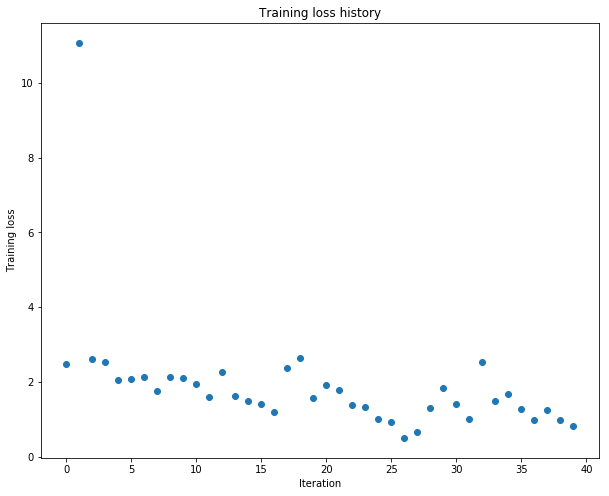

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 4e-2
weight_scale = 3.99e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=1, num_epochs=20, batch_size=20,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

In [ ]:
print(solver.check_accuracy(small_data['X_train'],small_data['y_train']))
print(solver.loss_history)

0.22
[2.302585092994045, 2.30121831273124, 2.2996542541211751, 2.2983393856427639, 2.2913481408920413, 2.278717213132686, 2.2846732185475167, 2.285375917123198, 2.2896937127210011, 2.3041132566070281, 2.2674468777206203, 2.2659759581085281, 2.2566604301725759, 2.2563932613272555, 2.2882601020827278, 2.2514067478510063, 2.2294477120025595, 2.2905004847347645, 2.2282378731411314, 2.2500555894054495, 2.2720547989495836, 2.2432515964363455, 2.2464659995625018, 2.2914189777789677, 2.2464453008977703, 2.2441797950354903, 2.279101911413945, 2.2067031675720892, 2.2319314388590019, 2.2509005023849951, 2.1794932143227861, 2.2871604009229962, 2.2511171386322006, 2.2433617316763761, 2.261225475916814, 2.2348708236337735, 2.1813475780866427, 2.3130202561330142, 2.2009337639571962, 2.1801223660563371]


# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

**Your answer:** *Fill in here*


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `dl4cv/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [ ]:
from dl4cv.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print 'next_w error: ', rel_error(next_w, expected_next_w)
print 'velocity error: ', rel_error(expected_velocity, config['velocity'])

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
('Shape of ', 'W1', ' is ', (3072, 100))
('Shape of ', 'b1', ' is ', (100,))
('Shape of ', 'W2', ' is ', (100, 100))
('Shape of ', 'b2', ' is ', (100,))
('Shape of ', 'W3', ' is ', (100, 100))
('Shape of ', 'b3', ' is ', (100,))
('Shape of ', 'W4', ' is ', (100, 100))
('Shape of ', 'b4', ' is ', (100,))
('Shape of ', 'W5', ' is ', (100, 100))
('Shape of ', 'b5', ' is ', (100,))
('Shape of ', 'W6', ' is ', (100, 10))
('Shape of ', 'b6', ' is ', (10,))
(Iteration 1 / 200) loss: 2.711258


(Epoch 0 / 5) train acc: 0.094000; val_acc: 0.127000


(Iteration 11 / 200) loss: 2.233815


(Iteration 21 / 200) loss: 2.055306


(Iteration 31 / 200) loss: 2.095432


(Epoch 1 / 5) train acc: 0.265000; val_acc: 0.227000
(Iteration 41 / 200) loss: 2.055982


(Iteration 51 / 200) loss: 1.894804


(Iteration 61 / 200) loss: 1.864632


(Iteration 71 / 200) loss: 1.882927


(Epoch 2 / 5) train acc: 0.336000; val_acc: 0.286000
(Iteration 81 / 200) loss: 1.933008


(Iteration 91 / 200) loss: 1.891095


(Iteration 101 / 200) loss: 1.621682


(Iteration 111 / 200) loss: 1.793588


(Epoch 3 / 5) train acc: 0.358000; val_acc: 0.316000
(Iteration 121 / 200) loss: 1.858436


(Iteration 131 / 200) loss: 1.788960


(Iteration 141 / 200) loss: 1.765863


(Iteration 151 / 200) loss: 1.597041


(Epoch 4 / 5) train acc: 0.429000; val_acc: 0.313000
(Iteration 161 / 200) loss: 1.599339


(Iteration 171 / 200) loss: 1.843636


(Iteration 181 / 200) loss: 1.571430


(Iteration 191 / 200) loss: 1.666605


(Epoch 5 / 5) train acc: 0.443000; val_acc: 0.313000

running with  sgd_momentum
('Shape of ', 'W1', ' is ', (3072, 100))
('Shape of ', 'b1', ' is ', (100,))
('Shape of ', 'W2', ' is ', (100, 100))
('Shape of ', 'b2', ' is ', (100,))
('Shape of ', 'W3', ' is ', (100, 100))
('Shape of ', 'b3', ' is ', (100,))
('Shape of ', 'W4', ' is ', (100, 100))
('Shape of ', 'b4', ' is ', (100,))
('Shape of ', 'W5', ' is ', (100, 100))
('Shape of ', 'b5', ' is ', (100,))
('Shape of ', 'W6', ' is ', (100, 10))
('Shape of ', 'b6', ' is ', (10,))
(Iteration 1 / 200) loss: 2.752604


(Epoch 0 / 5) train acc: 0.089000; val_acc: 0.099000


(Iteration 11 / 200) loss: 2.154534


(Iteration 21 / 200) loss: 2.090488


(Iteration 31 / 200) loss: 1.929354


(Epoch 1 / 5) train acc: 0.331000; val_acc: 0.302000
(Iteration 41 / 200) loss: 1.804952


(Iteration 51 / 200) loss: 1.705254


(Iteration 61 / 200) loss: 1.639576


(Iteration 71 / 200) loss: 1.599321


(Epoch 2 / 5) train acc: 0.385000; val_acc: 0.288000
(Iteration 81 / 200) loss: 1.771129


(Iteration 91 / 200) loss: 1.655581


(Iteration 101 / 200) loss: 1.780712


(Iteration 111 / 200) loss: 1.704939


(Epoch 3 / 5) train acc: 0.457000; val_acc: 0.325000
(Iteration 121 / 200) loss: 1.602865


(Iteration 131 / 200) loss: 1.417448


(Iteration 141 / 200) loss: 1.499992


(Iteration 151 / 200) loss: 1.394449


(Epoch 4 / 5) train acc: 0.469000; val_acc: 0.346000
(Iteration 161 / 200) loss: 1.502183


(Iteration 171 / 200) loss: 1.645585


(Iteration 181 / 200) loss: 1.259699


(Iteration 191 / 200) loss: 1.393465


(Epoch 5 / 5) train acc: 0.542000; val_acc: 0.315000



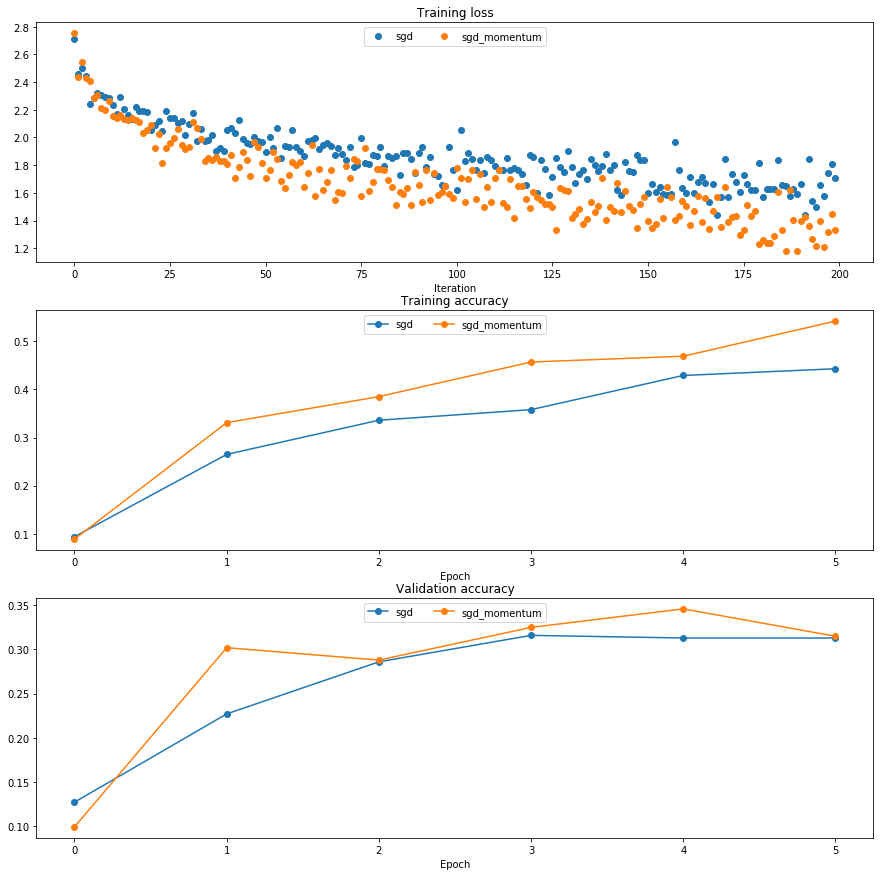

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print 'running with ', update_rule
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Adam
Adam [1] is an update rule that sets per-parameter learning rates by using a running average of the second moments of gradients.

In the file `dl4cv/optim.py`, we have implemented the update rule `adam` for you. Check this implementation and make sure you understand what the optimizer is doing. Then train the fully connected net below to see how Adam affects the learning process.

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

running with  adam
('Shape of ', 'W1', ' is ', (3072, 100))
('Shape of ', 'b1', ' is ', (100,))
('Shape of ', 'W2', ' is ', (100, 100))
('Shape of ', 'b2', ' is ', (100,))
('Shape of ', 'W3', ' is ', (100, 100))
('Shape of ', 'b3', ' is ', (100,))
('Shape of ', 'W4', ' is ', (100, 100))
('Shape of ', 'b4', ' is ', (100,))
('Shape of ', 'W5', ' is ', (100, 100))
('Shape of ', 'b5', ' is ', (100,))
('Shape of ', 'W6', ' is ', (100, 10))
('Shape of ', 'b6', ' is ', (10,))
(Iteration 1 / 600) loss: 27.511812


(Epoch 0 / 30) train acc: 0.161000; val_acc: 0.151000


(Iteration 11 / 600) loss: 23.329045


(Epoch 1 / 30) train acc: 0.357000; val_acc: 0.273000
(Iteration 21 / 600) loss: 20.021876


(Iteration 31 / 600) loss: 17.061093


(Epoch 2 / 30) train acc: 0.398000; val_acc: 0.334000
(Iteration 41 / 600) loss: 14.483872


(Iteration 51 / 600) loss: 12.584922


(Epoch 3 / 30) train acc: 0.450000; val_acc: 0.364000
(Iteration 61 / 600) loss: 10.894959


(Iteration 71 / 600) loss: 9.357091


(Epoch 4 / 30) train acc: 0.479000; val_acc: 0.362000
(Iteration 81 / 600) loss: 8.302325


(Iteration 91 / 600) loss: 7.359226


(Epoch 5 / 30) train acc: 0.523000; val_acc: 0.370000
(Iteration 101 / 600) loss: 6.667314


(Iteration 111 / 600) loss: 5.851686


(Epoch 6 / 30) train acc: 0.523000; val_acc: 0.388000
(Iteration 121 / 600) loss: 5.239081


(Iteration 131 / 600) loss: 4.947731


(Epoch 7 / 30) train acc: 0.535000; val_acc: 0.393000
(Iteration 141 / 600) loss: 4.452157


(Iteration 151 / 600) loss: 4.113696


(Epoch 8 / 30) train acc: 0.582000; val_acc: 0.399000
(Iteration 161 / 600) loss: 3.758118


(Iteration 171 / 600) loss: 3.528537


(Epoch 9 / 30) train acc: 0.584000; val_acc: 0.399000
(Iteration 181 / 600) loss: 3.315457


(Iteration 191 / 600) loss: 3.036026


(Epoch 10 / 30) train acc: 0.603000; val_acc: 0.356000
(Iteration 201 / 600) loss: 3.160191


(Iteration 211 / 600) loss: 2.953476


(Epoch 11 / 30) train acc: 0.587000; val_acc: 0.370000
(Iteration 221 / 600) loss: 2.745615


(Iteration 231 / 600) loss: 2.668920


(Epoch 12 / 30) train acc: 0.629000; val_acc: 0.397000
(Iteration 241 / 600) loss: 2.569547


(Iteration 251 / 600) loss: 2.471937


(Epoch 13 / 30) train acc: 0.639000; val_acc: 0.411000
(Iteration 261 / 600) loss: 2.258668


(Iteration 271 / 600) loss: 2.350712


(Epoch 14 / 30) train acc: 0.632000; val_acc: 0.377000
(Iteration 281 / 600) loss: 2.233101


(Iteration 291 / 600) loss: 2.130066


(Epoch 15 / 30) train acc: 0.661000; val_acc: 0.384000
(Iteration 301 / 600) loss: 2.298645


(Iteration 311 / 600) loss: 2.305256


(Epoch 16 / 30) train acc: 0.627000; val_acc: 0.395000
(Iteration 321 / 600) loss: 2.114426


(Iteration 331 / 600) loss: 2.096058


(Epoch 17 / 30) train acc: 0.672000; val_acc: 0.394000
(Iteration 341 / 600) loss: 1.961995


(Iteration 351 / 600) loss: 2.087632


(Epoch 18 / 30) train acc: 0.695000; val_acc: 0.395000
(Iteration 361 / 600) loss: 2.016745


(Iteration 371 / 600) loss: 1.851076


(Epoch 19 / 30) train acc: 0.650000; val_acc: 0.386000
(Iteration 381 / 600) loss: 1.947413


(Iteration 391 / 600) loss: 1.958287


(Epoch 20 / 30) train acc: 0.696000; val_acc: 0.378000
(Iteration 401 / 600) loss: 1.834042


(Iteration 411 / 600) loss: 1.833582


(Epoch 21 / 30) train acc: 0.706000; val_acc: 0.403000
(Iteration 421 / 600) loss: 1.796269


(Iteration 431 / 600) loss: 1.813140


(Epoch 22 / 30) train acc: 0.740000; val_acc: 0.370000
(Iteration 441 / 600) loss: 1.722632


(Iteration 451 / 600) loss: 1.720815


(Epoch 23 / 30) train acc: 0.689000; val_acc: 0.388000
(Iteration 461 / 600) loss: 1.718140


(Iteration 471 / 600) loss: 1.831215


(Epoch 24 / 30) train acc: 0.669000; val_acc: 0.355000
(Iteration 481 / 600) loss: 1.834920


(Iteration 491 / 600) loss: 1.715216


(Epoch 25 / 30) train acc: 0.670000; val_acc: 0.366000
(Iteration 501 / 600) loss: 1.753122


(Iteration 511 / 600) loss: 1.772718


(Epoch 26 / 30) train acc: 0.732000; val_acc: 0.380000
(Iteration 521 / 600) loss: 1.658126


(Iteration 531 / 600) loss: 1.748564


(Epoch 27 / 30) train acc: 0.736000; val_acc: 0.374000
(Iteration 541 / 600) loss: 1.617006


(Iteration 551 / 600) loss: 1.745712


(Epoch 28 / 30) train acc: 0.716000; val_acc: 0.382000
(Iteration 561 / 600) loss: 1.646503


(Iteration 571 / 600) loss: 1.792707


(Epoch 29 / 30) train acc: 0.744000; val_acc: 0.385000
(Iteration 581 / 600) loss: 1.734886


(Iteration 591 / 600) loss: 1.554519


(Epoch 30 / 30) train acc: 0.772000; val_acc: 0.390000



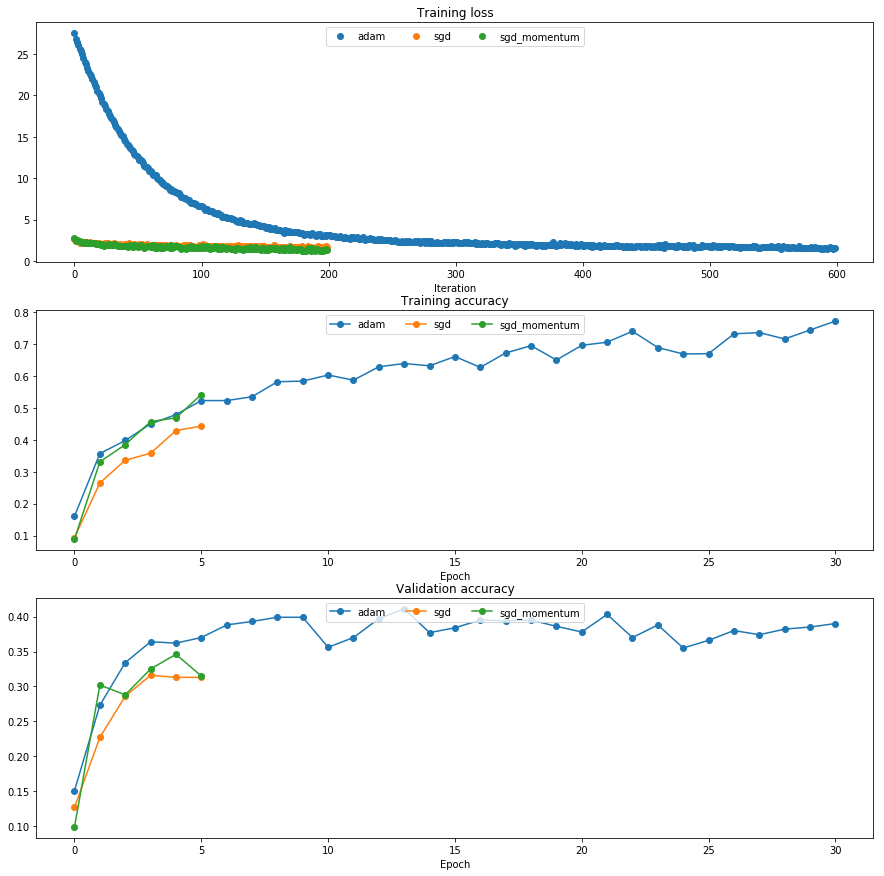

In [ ]:
learning_rates = {'adam': 0.4e-3}
update_rule = 'adam'
print 'running with ', update_rule
model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5.1e-2, reg=0.055)

solver = Solver(model, small_data,
              num_epochs=30, batch_size=200,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rates[update_rule]
              },
              verbose=True)
solvers[update_rule] = solver
solver.train()
print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 48% accuracy on the validation set using a fully-connected net.

You might find it useful to complete the `2_BatchNormalization.ipynb` notebook before completing this part, since this technique can help you train powerful models.

In [12]:
from dl4cv.data_utils import cartesian
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
# Note that dropout is not required to pass beyond the linear scoring regime   #
################################################################################
#pass
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}

best_model = None

best_val = -1
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [5e4, 1e5]

update_rule = 'adam'
print 'running with ', update_rule

learning_rates = [0.001]#[1e-3]#[1e-6,1e-5,1e-4,1e-3,1e-2]#[1e-10,5e-10,1e-9,5e-9,1e-8,5e-8,1e-7,5e-7]
regularization_strengths = [0.0]#[0.1]#[1e1,5e1,1e2,5e2,1e3,5e3,1e4,5e4,1e5,5e5]
learning_rate_decay = [1.0]#[0.95,0.85]

hyperparameters=cartesian((learning_rates,learning_rate_decay,regularization_strengths))
hyp = np.zeros(hyperparameters.shape[1])

best_vals = (0,0)
best_key = (0,0)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']

for i in range(len(hyperparameters)):

    hyp = hyperparameters[i]

    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=0.04, reg=hyp[2])

    solver = Solver(model, data,
                  num_epochs=30, batch_size=200,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': hyp[0]
                  },lr_decay=hyp[1],
                  verbose=True)
    #solvers[update_rule] = solver
    solver.train()

    y_train_pred = np.argmax(model.loss(X_train), axis=1)
    y_val_pred = np.argmax(model.loss(X_val), axis=1)
    train_accuracy = (y_train_pred == y_train).mean()
    val_acc = (y_val_pred == y_val).mean()

    results[(hyp[0],hyp[1],hyp[2])] = train_accuracy,val_acc
    if(best_vals[1] < results[(hyp[0],hyp[1],hyp[2])][1]):
        best_vals = train_accuracy,val_acc
        best_key = (hyp[0],hyp[1],hyp[2])
        best_model = model

#print(results)

for lr,lr_d,reg in sorted(results):
    acc = results[(lr, lr_d, reg)]
    print ('lr: ', lr, "lr_d: ", lr_d, "reg: ", reg, "      acc: ", acc)

trainagain = False

#best_val=best_vals[1]
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

running with  adam
('Shape of ', 'W1', ' is ', (3072, 100))
('Shape of ', 'b1', ' is ', (100,))
('Shape of ', 'W2', ' is ', (100, 100))
('Shape of ', 'b2', ' is ', (100,))
('Shape of ', 'W3', ' is ', (100, 100))
('Shape of ', 'b3', ' is ', (100,))
('Shape of ', 'W4', ' is ', (100, 100))
('Shape of ', 'b4', ' is ', (100,))
('Shape of ', 'W5', ' is ', (100, 100))
('Shape of ', 'b5', ' is ', (100,))
('Shape of ', 'W6', ' is ', (100, 10))
('Shape of ', 'b6', ' is ', (10,))
(Iteration 1 / 7200) loss: 2.346195


(Epoch 0 / 30) train acc: 0.134000; val_acc: 0.144000


(Iteration 11 / 7200) loss: 1.929554


(Iteration 21 / 7200) loss: 1.901728


(Iteration 31 / 7200) loss: 1.946764


(Iteration 41 / 7200) loss: 1.829847


(Iteration 51 / 7200) loss: 1.778113


(Iteration 61 / 7200) loss: 1.766464


(Iteration 71 / 7200) loss: 1.652260


(Iteration 81 / 7200) loss: 1.711696


(Iteration 91 / 7200) loss: 1.579089


(Iteration 101 / 7200) loss: 1.664980


(Iteration 111 / 7200) loss: 1.714309


(Iteration 121 / 7200) loss: 1.571557


(Iteration 131 / 7200) loss: 1.739076


(Iteration 141 / 7200) loss: 1.650233


(Iteration 151 / 7200) loss: 1.605316


(Iteration 161 / 7200) loss: 1.739910


(Iteration 171 / 7200) loss: 1.542133


(Iteration 181 / 7200) loss: 1.642844


(Iteration 191 / 7200) loss: 1.606403


(Iteration 201 / 7200) loss: 1.396308


(Iteration 211 / 7200) loss: 1.518112


(Iteration 221 / 7200) loss: 1.550162


(Iteration 231 / 7200) loss: 1.497154


(Epoch 1 / 30) train acc: 0.437000; val_acc: 0.430000
(Iteration 241 / 7200) loss: 1.638597


(Iteration 251 / 7200) loss: 1.473061


(Iteration 261 / 7200) loss: 1.486585


(Iteration 271 / 7200) loss: 1.618846


(Iteration 281 / 7200) loss: 1.619632


(Iteration 291 / 7200) loss: 1.471160


(Iteration 301 / 7200) loss: 1.532726


(Iteration 311 / 7200) loss: 1.428172


(Iteration 321 / 7200) loss: 1.431262


(Iteration 331 / 7200) loss: 1.377851


(Iteration 341 / 7200) loss: 1.561252


(Iteration 351 / 7200) loss: 1.457394


(Iteration 361 / 7200) loss: 1.359500


(Iteration 371 / 7200) loss: 1.344772


(Iteration 381 / 7200) loss: 1.412899


(Iteration 391 / 7200) loss: 1.424370


(Iteration 401 / 7200) loss: 1.401529


(Iteration 411 / 7200) loss: 1.543026


(Iteration 421 / 7200) loss: 1.368445


(Iteration 431 / 7200) loss: 1.574880


(Iteration 441 / 7200) loss: 1.513696


(Iteration 451 / 7200) loss: 1.506708


(Iteration 461 / 7200) loss: 1.478414


(Iteration 471 / 7200) loss: 1.404660


(Epoch 2 / 30) train acc: 0.501000; val_acc: 0.475000
(Iteration 481 / 7200) loss: 1.614922


(Iteration 491 / 7200) loss: 1.398013


(Iteration 501 / 7200) loss: 1.408462


(Iteration 511 / 7200) loss: 1.522093


(Iteration 521 / 7200) loss: 1.394420


(Iteration 531 / 7200) loss: 1.367496


(Iteration 541 / 7200) loss: 1.551778


(Iteration 551 / 7200) loss: 1.405981


(Iteration 561 / 7200) loss: 1.397222


(Iteration 571 / 7200) loss: 1.268675


(Iteration 581 / 7200) loss: 1.350455


(Iteration 591 / 7200) loss: 1.399761


(Iteration 601 / 7200) loss: 1.499685


(Iteration 611 / 7200) loss: 1.370352


(Iteration 621 / 7200) loss: 1.413987


(Iteration 631 / 7200) loss: 1.497201


(Iteration 641 / 7200) loss: 1.369966


(Iteration 651 / 7200) loss: 1.206321


(Iteration 661 / 7200) loss: 1.388438


(Iteration 671 / 7200) loss: 1.539720


(Iteration 681 / 7200) loss: 1.317489


(Iteration 691 / 7200) loss: 1.480876


(Iteration 701 / 7200) loss: 1.397692


(Iteration 711 / 7200) loss: 1.399286


(Epoch 3 / 30) train acc: 0.528000; val_acc: 0.488000
(Iteration 721 / 7200) loss: 1.364940


(Iteration 731 / 7200) loss: 1.383020


(Iteration 741 / 7200) loss: 1.312144


(Iteration 751 / 7200) loss: 1.293019


(Iteration 761 / 7200) loss: 1.255157


(Iteration 771 / 7200) loss: 1.329627


(Iteration 781 / 7200) loss: 1.252603


(Iteration 791 / 7200) loss: 1.344824


(Iteration 801 / 7200) loss: 1.349827


(Iteration 811 / 7200) loss: 1.284233


(Iteration 821 / 7200) loss: 1.348640


(Iteration 831 / 7200) loss: 1.307734


(Iteration 841 / 7200) loss: 1.407215


(Iteration 851 / 7200) loss: 1.348877


(Iteration 861 / 7200) loss: 1.321142


(Iteration 871 / 7200) loss: 1.411866


(Iteration 881 / 7200) loss: 1.377368


(Iteration 891 / 7200) loss: 1.232592


(Iteration 901 / 7200) loss: 1.288412


(Iteration 911 / 7200) loss: 1.278156


(Iteration 921 / 7200) loss: 1.297713


(Iteration 931 / 7200) loss: 1.348935


(Iteration 941 / 7200) loss: 1.352021


(Iteration 951 / 7200) loss: 1.220068


(Epoch 4 / 30) train acc: 0.558000; val_acc: 0.495000
(Iteration 961 / 7200) loss: 1.238804


(Iteration 971 / 7200) loss: 1.223542


(Iteration 981 / 7200) loss: 1.331141


(Iteration 991 / 7200) loss: 1.293580


(Iteration 1001 / 7200) loss: 1.227053


(Iteration 1011 / 7200) loss: 1.283437


(Iteration 1021 / 7200) loss: 1.205108


(Iteration 1031 / 7200) loss: 1.260235


(Iteration 1041 / 7200) loss: 1.339146


(Iteration 1051 / 7200) loss: 1.227771


(Iteration 1061 / 7200) loss: 1.225509


(Iteration 1071 / 7200) loss: 1.253026


(Iteration 1081 / 7200) loss: 1.223835


(Iteration 1091 / 7200) loss: 1.252209


(Iteration 1101 / 7200) loss: 1.234471


(Iteration 1111 / 7200) loss: 1.239352


(Iteration 1121 / 7200) loss: 1.218380


(Iteration 1131 / 7200) loss: 1.136401


(Iteration 1141 / 7200) loss: 1.379424


(Iteration 1151 / 7200) loss: 1.379349


(Iteration 1161 / 7200) loss: 1.228448


(Iteration 1171 / 7200) loss: 1.324216


(Iteration 1181 / 7200) loss: 1.219429


(Iteration 1191 / 7200) loss: 1.298917


(Epoch 5 / 30) train acc: 0.575000; val_acc: 0.508000
(Iteration 1201 / 7200) loss: 1.156393


(Iteration 1211 / 7200) loss: 1.109745


(Iteration 1221 / 7200) loss: 1.142291


(Iteration 1231 / 7200) loss: 1.165267


(Iteration 1241 / 7200) loss: 1.166608


(Iteration 1251 / 7200) loss: 1.200901


(Iteration 1261 / 7200) loss: 1.223283


(Iteration 1271 / 7200) loss: 1.444532


(Iteration 1281 / 7200) loss: 1.359453


(Iteration 1291 / 7200) loss: 1.195092


(Iteration 1301 / 7200) loss: 1.218427


(Iteration 1311 / 7200) loss: 1.127177


(Iteration 1321 / 7200) loss: 1.272689


(Iteration 1331 / 7200) loss: 1.096878


(Iteration 1341 / 7200) loss: 1.193237


(Iteration 1351 / 7200) loss: 1.123441


(Iteration 1361 / 7200) loss: 1.025970


(Iteration 1371 / 7200) loss: 1.234440


(Iteration 1381 / 7200) loss: 1.194371


(Iteration 1391 / 7200) loss: 1.045639


(Iteration 1401 / 7200) loss: 1.242573


(Iteration 1411 / 7200) loss: 1.170411


(Iteration 1421 / 7200) loss: 1.162053


(Iteration 1431 / 7200) loss: 1.277643


(Epoch 6 / 30) train acc: 0.543000; val_acc: 0.512000
(Iteration 1441 / 7200) loss: 1.077590


(Iteration 1451 / 7200) loss: 1.346184


(Iteration 1461 / 7200) loss: 1.142337


(Iteration 1471 / 7200) loss: 1.119957


(Iteration 1481 / 7200) loss: 1.186882


(Iteration 1491 / 7200) loss: 1.155560


(Iteration 1501 / 7200) loss: 1.130605


(Iteration 1511 / 7200) loss: 1.098170


(Iteration 1521 / 7200) loss: 1.131859


(Iteration 1531 / 7200) loss: 1.280061


(Iteration 1541 / 7200) loss: 1.159550


(Iteration 1551 / 7200) loss: 1.147965


(Iteration 1561 / 7200) loss: 1.196872


(Iteration 1571 / 7200) loss: 1.222188


(Iteration 1581 / 7200) loss: 1.249606


(Iteration 1591 / 7200) loss: 1.198454


(Iteration 1601 / 7200) loss: 1.134733


(Iteration 1611 / 7200) loss: 1.193474


(Iteration 1621 / 7200) loss: 1.216299


(Iteration 1631 / 7200) loss: 1.058851


(Iteration 1641 / 7200) loss: 1.076366


(Iteration 1651 / 7200) loss: 1.291036


(Iteration 1661 / 7200) loss: 1.165139


(Iteration 1671 / 7200) loss: 1.219801


(Epoch 7 / 30) train acc: 0.595000; val_acc: 0.518000
(Iteration 1681 / 7200) loss: 1.140973


(Iteration 1691 / 7200) loss: 1.165578


(Iteration 1701 / 7200) loss: 1.208973


(Iteration 1711 / 7200) loss: 1.268443


(Iteration 1721 / 7200) loss: 1.194086


(Iteration 1731 / 7200) loss: 1.126102


(Iteration 1741 / 7200) loss: 1.241706


(Iteration 1751 / 7200) loss: 1.204615


(Iteration 1761 / 7200) loss: 1.162600


(Iteration 1771 / 7200) loss: 1.089014


(Iteration 1781 / 7200) loss: 1.024161


(Iteration 1791 / 7200) loss: 1.064184


(Iteration 1801 / 7200) loss: 1.021558


(Iteration 1811 / 7200) loss: 1.110940


(Iteration 1821 / 7200) loss: 1.205318


(Iteration 1831 / 7200) loss: 1.034774


(Iteration 1841 / 7200) loss: 1.069679


(Iteration 1851 / 7200) loss: 1.053774


(Iteration 1861 / 7200) loss: 1.024870


(Iteration 1871 / 7200) loss: 1.034420


(Iteration 1881 / 7200) loss: 1.274127


(Iteration 1891 / 7200) loss: 1.055905


(Iteration 1901 / 7200) loss: 1.097589


(Iteration 1911 / 7200) loss: 1.140573


(Epoch 8 / 30) train acc: 0.605000; val_acc: 0.513000
(Iteration 1921 / 7200) loss: 0.990397


(Iteration 1931 / 7200) loss: 1.274848


(Iteration 1941 / 7200) loss: 1.063928


(Iteration 1951 / 7200) loss: 1.138394


(Iteration 1961 / 7200) loss: 1.140376


(Iteration 1971 / 7200) loss: 1.158637


(Iteration 1981 / 7200) loss: 1.105018


(Iteration 1991 / 7200) loss: 1.252790


(Iteration 2001 / 7200) loss: 1.109153


(Iteration 2011 / 7200) loss: 1.062907


(Iteration 2021 / 7200) loss: 1.220603


(Iteration 2031 / 7200) loss: 1.143587


(Iteration 2041 / 7200) loss: 0.986620


(Iteration 2051 / 7200) loss: 1.141363


(Iteration 2061 / 7200) loss: 1.159046


(Iteration 2071 / 7200) loss: 0.985898


(Iteration 2081 / 7200) loss: 1.091070


(Iteration 2091 / 7200) loss: 1.067036


(Iteration 2101 / 7200) loss: 1.086272


(Iteration 2111 / 7200) loss: 1.066228


(Iteration 2121 / 7200) loss: 1.005223


(Iteration 2131 / 7200) loss: 1.000697


(Iteration 2141 / 7200) loss: 1.063151


(Iteration 2151 / 7200) loss: 1.120628


(Epoch 9 / 30) train acc: 0.656000; val_acc: 0.517000
(Iteration 2161 / 7200) loss: 1.120891


(Iteration 2171 / 7200) loss: 1.016598


(Iteration 2181 / 7200) loss: 0.967273


(Iteration 2191 / 7200) loss: 1.085836


(Iteration 2201 / 7200) loss: 1.031442


(Iteration 2211 / 7200) loss: 1.022815


(Iteration 2221 / 7200) loss: 1.093327


(Iteration 2231 / 7200) loss: 1.074271


(Iteration 2241 / 7200) loss: 1.037170


(Iteration 2251 / 7200) loss: 1.050542


(Iteration 2261 / 7200) loss: 1.181106


(Iteration 2271 / 7200) loss: 1.225902


(Iteration 2281 / 7200) loss: 0.979590


(Iteration 2291 / 7200) loss: 1.133069


(Iteration 2301 / 7200) loss: 1.037738


(Iteration 2311 / 7200) loss: 0.934626


(Iteration 2321 / 7200) loss: 1.102156


(Iteration 2331 / 7200) loss: 1.058009


(Iteration 2341 / 7200) loss: 1.163774


(Iteration 2351 / 7200) loss: 0.976509


(Iteration 2361 / 7200) loss: 0.892943


(Iteration 2371 / 7200) loss: 0.985261


(Iteration 2381 / 7200) loss: 1.089824


(Iteration 2391 / 7200) loss: 0.900128


(Epoch 10 / 30) train acc: 0.636000; val_acc: 0.534000
(Iteration 2401 / 7200) loss: 1.043725


(Iteration 2411 / 7200) loss: 0.976557


(Iteration 2421 / 7200) loss: 1.082121


(Iteration 2431 / 7200) loss: 0.915843


(Iteration 2441 / 7200) loss: 1.033274


(Iteration 2451 / 7200) loss: 1.056312


(Iteration 2461 / 7200) loss: 1.009088


(Iteration 2471 / 7200) loss: 1.170917


(Iteration 2481 / 7200) loss: 1.142470


(Iteration 2491 / 7200) loss: 0.997342


(Iteration 2501 / 7200) loss: 1.090832


(Iteration 2511 / 7200) loss: 1.094711


(Iteration 2521 / 7200) loss: 1.095749


(Iteration 2531 / 7200) loss: 0.882560


(Iteration 2541 / 7200) loss: 1.017156


(Iteration 2551 / 7200) loss: 0.991870


(Iteration 2561 / 7200) loss: 0.790576


(Iteration 2571 / 7200) loss: 1.020470


(Iteration 2581 / 7200) loss: 1.109348


(Iteration 2591 / 7200) loss: 0.958566


(Iteration 2601 / 7200) loss: 1.041472


(Iteration 2611 / 7200) loss: 0.997265


(Iteration 2621 / 7200) loss: 0.928405


(Iteration 2631 / 7200) loss: 1.014435


(Epoch 11 / 30) train acc: 0.640000; val_acc: 0.531000
(Iteration 2641 / 7200) loss: 1.000514


(Iteration 2651 / 7200) loss: 0.933801


(Iteration 2661 / 7200) loss: 1.007998


(Iteration 2671 / 7200) loss: 1.102847


(Iteration 2681 / 7200) loss: 1.087352


(Iteration 2691 / 7200) loss: 1.084158


(Iteration 2701 / 7200) loss: 1.014064


(Iteration 2711 / 7200) loss: 0.764450


(Iteration 2721 / 7200) loss: 0.928653


(Iteration 2731 / 7200) loss: 1.029936


(Iteration 2741 / 7200) loss: 1.020327


(Iteration 2751 / 7200) loss: 1.158848


(Iteration 2761 / 7200) loss: 1.061339


(Iteration 2771 / 7200) loss: 1.137941


(Iteration 2781 / 7200) loss: 0.902034


(Iteration 2791 / 7200) loss: 0.937926


(Iteration 2801 / 7200) loss: 1.012081


(Iteration 2811 / 7200) loss: 0.770973


(Iteration 2821 / 7200) loss: 0.886098


(Iteration 2831 / 7200) loss: 1.005416


(Iteration 2841 / 7200) loss: 0.915221


(Iteration 2851 / 7200) loss: 1.000743


(Iteration 2861 / 7200) loss: 1.116490


(Iteration 2871 / 7200) loss: 1.034548


(Epoch 12 / 30) train acc: 0.657000; val_acc: 0.499000
(Iteration 2881 / 7200) loss: 0.906593


(Iteration 2891 / 7200) loss: 0.948538


(Iteration 2901 / 7200) loss: 1.036606


(Iteration 2911 / 7200) loss: 1.026733


(Iteration 2921 / 7200) loss: 0.935044


(Iteration 2931 / 7200) loss: 1.054839


(Iteration 2941 / 7200) loss: 0.850037


(Iteration 2951 / 7200) loss: 0.917642


(Iteration 2961 / 7200) loss: 0.879311


(Iteration 2971 / 7200) loss: 0.968673


(Iteration 2981 / 7200) loss: 0.823047


(Iteration 2991 / 7200) loss: 0.963253


(Iteration 3001 / 7200) loss: 1.008320


(Iteration 3011 / 7200) loss: 0.865515


(Iteration 3021 / 7200) loss: 0.891928


(Iteration 3031 / 7200) loss: 0.906939


(Iteration 3041 / 7200) loss: 1.011967


(Iteration 3051 / 7200) loss: 1.013868


(Iteration 3061 / 7200) loss: 0.819214


(Iteration 3071 / 7200) loss: 1.009414


(Iteration 3081 / 7200) loss: 0.908621


(Iteration 3091 / 7200) loss: 1.189497


(Iteration 3101 / 7200) loss: 0.895187


(Iteration 3111 / 7200) loss: 0.968867


(Epoch 13 / 30) train acc: 0.636000; val_acc: 0.526000
(Iteration 3121 / 7200) loss: 1.107152


(Iteration 3131 / 7200) loss: 1.011061


(Iteration 3141 / 7200) loss: 0.828668


(Iteration 3151 / 7200) loss: 1.072678


(Iteration 3161 / 7200) loss: 0.824332


(Iteration 3171 / 7200) loss: 1.034058


(Iteration 3181 / 7200) loss: 0.880944


(Iteration 3191 / 7200) loss: 0.981280


(Iteration 3201 / 7200) loss: 0.816520


(Iteration 3211 / 7200) loss: 1.042204


(Iteration 3221 / 7200) loss: 0.955995


(Iteration 3231 / 7200) loss: 1.037495


(Iteration 3241 / 7200) loss: 0.905364


(Iteration 3251 / 7200) loss: 0.884683


(Iteration 3261 / 7200) loss: 0.991051


(Iteration 3271 / 7200) loss: 1.051359


(Iteration 3281 / 7200) loss: 0.978734


(Iteration 3291 / 7200) loss: 1.089827


(Iteration 3301 / 7200) loss: 0.951859


(Iteration 3311 / 7200) loss: 0.954296


(Iteration 3321 / 7200) loss: 0.995961


(Iteration 3331 / 7200) loss: 1.107329


(Iteration 3341 / 7200) loss: 0.970913


(Iteration 3351 / 7200) loss: 0.835747


(Epoch 14 / 30) train acc: 0.692000; val_acc: 0.525000
(Iteration 3361 / 7200) loss: 0.850933


(Iteration 3371 / 7200) loss: 0.967707


(Iteration 3381 / 7200) loss: 0.804634


(Iteration 3391 / 7200) loss: 0.968439


(Iteration 3401 / 7200) loss: 0.762644


(Iteration 3411 / 7200) loss: 0.852109


(Iteration 3421 / 7200) loss: 0.856441


(Iteration 3431 / 7200) loss: 1.105994


(Iteration 3441 / 7200) loss: 0.974530


(Iteration 3451 / 7200) loss: 1.016505


(Iteration 3461 / 7200) loss: 0.931673


(Iteration 3471 / 7200) loss: 0.975177


(Iteration 3481 / 7200) loss: 0.843759


(Iteration 3491 / 7200) loss: 0.894210


(Iteration 3501 / 7200) loss: 0.922790


(Iteration 3511 / 7200) loss: 0.918014


(Iteration 3521 / 7200) loss: 1.029399


(Iteration 3531 / 7200) loss: 1.012047


(Iteration 3541 / 7200) loss: 0.893023


(Iteration 3551 / 7200) loss: 0.967227


(Iteration 3561 / 7200) loss: 0.934200


(Iteration 3571 / 7200) loss: 0.949731


(Iteration 3581 / 7200) loss: 0.983593


(Iteration 3591 / 7200) loss: 0.852851


(Epoch 15 / 30) train acc: 0.671000; val_acc: 0.521000
(Iteration 3601 / 7200) loss: 0.801888


(Iteration 3611 / 7200) loss: 0.898551


(Iteration 3621 / 7200) loss: 0.866386


(Iteration 3631 / 7200) loss: 1.061023


(Iteration 3641 / 7200) loss: 0.921918


(Iteration 3651 / 7200) loss: 0.744961


(Iteration 3661 / 7200) loss: 0.892127


(Iteration 3671 / 7200) loss: 0.854429


(Iteration 3681 / 7200) loss: 0.940160


(Iteration 3691 / 7200) loss: 0.907640


(Iteration 3701 / 7200) loss: 0.904005


(Iteration 3711 / 7200) loss: 0.803526


(Iteration 3721 / 7200) loss: 0.995902


(Iteration 3731 / 7200) loss: 1.000333


(Iteration 3741 / 7200) loss: 0.876326


(Iteration 3751 / 7200) loss: 0.788053


(Iteration 3761 / 7200) loss: 0.880492


(Iteration 3771 / 7200) loss: 0.768962


(Iteration 3781 / 7200) loss: 0.859827


(Iteration 3791 / 7200) loss: 0.872465


(Iteration 3801 / 7200) loss: 0.894501


(Iteration 3811 / 7200) loss: 0.906855


(Iteration 3821 / 7200) loss: 0.912877


(Iteration 3831 / 7200) loss: 0.922374


(Epoch 16 / 30) train acc: 0.701000; val_acc: 0.515000
(Iteration 3841 / 7200) loss: 0.956620


(Iteration 3851 / 7200) loss: 0.792789


(Iteration 3861 / 7200) loss: 0.883142


(Iteration 3871 / 7200) loss: 0.828747


(Iteration 3881 / 7200) loss: 0.962965


(Iteration 3891 / 7200) loss: 0.834357


(Iteration 3901 / 7200) loss: 0.827192


(Iteration 3911 / 7200) loss: 0.830332


(Iteration 3921 / 7200) loss: 0.890189


(Iteration 3931 / 7200) loss: 0.756665


(Iteration 3941 / 7200) loss: 0.916322


(Iteration 3951 / 7200) loss: 0.832621


(Iteration 3961 / 7200) loss: 0.799102


(Iteration 3971 / 7200) loss: 0.919893


(Iteration 3981 / 7200) loss: 0.873298


(Iteration 3991 / 7200) loss: 0.786621


(Iteration 4001 / 7200) loss: 0.847498


(Iteration 4011 / 7200) loss: 0.805297


(Iteration 4021 / 7200) loss: 0.945648


(Iteration 4031 / 7200) loss: 0.891135


(Iteration 4041 / 7200) loss: 0.839033


(Iteration 4051 / 7200) loss: 0.864241


(Iteration 4061 / 7200) loss: 1.013001


(Iteration 4071 / 7200) loss: 0.843031


(Epoch 17 / 30) train acc: 0.690000; val_acc: 0.526000
(Iteration 4081 / 7200) loss: 0.828495


(Iteration 4091 / 7200) loss: 0.888397


(Iteration 4101 / 7200) loss: 0.882477


(Iteration 4111 / 7200) loss: 0.882743


(Iteration 4121 / 7200) loss: 0.860680


(Iteration 4131 / 7200) loss: 1.102048


(Iteration 4141 / 7200) loss: 0.866108


(Iteration 4151 / 7200) loss: 0.638928


(Iteration 4161 / 7200) loss: 0.842208


(Iteration 4171 / 7200) loss: 0.808327


(Iteration 4181 / 7200) loss: 0.812622


(Iteration 4191 / 7200) loss: 0.904629


(Iteration 4201 / 7200) loss: 0.956612


(Iteration 4211 / 7200) loss: 0.906785


(Iteration 4221 / 7200) loss: 0.781394


(Iteration 4231 / 7200) loss: 0.912649


(Iteration 4241 / 7200) loss: 0.956340


(Iteration 4251 / 7200) loss: 0.642406


(Iteration 4261 / 7200) loss: 0.885550


(Iteration 4271 / 7200) loss: 0.851935


(Iteration 4281 / 7200) loss: 0.965591


(Iteration 4291 / 7200) loss: 0.777541


(Iteration 4301 / 7200) loss: 0.872991


(Iteration 4311 / 7200) loss: 0.866618


(Epoch 18 / 30) train acc: 0.715000; val_acc: 0.513000
(Iteration 4321 / 7200) loss: 0.795362


(Iteration 4331 / 7200) loss: 0.846538


(Iteration 4341 / 7200) loss: 0.873406


(Iteration 4351 / 7200) loss: 0.916776


(Iteration 4361 / 7200) loss: 0.902265


(Iteration 4371 / 7200) loss: 0.750189


(Iteration 4381 / 7200) loss: 0.813945


(Iteration 4391 / 7200) loss: 0.908020


(Iteration 4401 / 7200) loss: 0.871094


(Iteration 4411 / 7200) loss: 0.896406


(Iteration 4421 / 7200) loss: 0.880332


(Iteration 4431 / 7200) loss: 0.879750


(Iteration 4441 / 7200) loss: 0.743969


(Iteration 4451 / 7200) loss: 0.870665


(Iteration 4461 / 7200) loss: 0.794138


(Iteration 4471 / 7200) loss: 0.819939


(Iteration 4481 / 7200) loss: 0.905604


(Iteration 4491 / 7200) loss: 0.788289


(Iteration 4501 / 7200) loss: 0.894698


(Iteration 4511 / 7200) loss: 0.823616


(Iteration 4521 / 7200) loss: 1.026656


(Iteration 4531 / 7200) loss: 0.744323


(Iteration 4541 / 7200) loss: 0.883450


(Iteration 4551 / 7200) loss: 0.804453


(Epoch 19 / 30) train acc: 0.701000; val_acc: 0.522000
(Iteration 4561 / 7200) loss: 0.819596


(Iteration 4571 / 7200) loss: 0.832265


(Iteration 4581 / 7200) loss: 0.793604


(Iteration 4591 / 7200) loss: 0.742706


(Iteration 4601 / 7200) loss: 0.706925


(Iteration 4611 / 7200) loss: 0.778180


(Iteration 4621 / 7200) loss: 0.975193


(Iteration 4631 / 7200) loss: 0.822783


(Iteration 4641 / 7200) loss: 0.784957


(Iteration 4651 / 7200) loss: 0.753772


(Iteration 4661 / 7200) loss: 0.755765


(Iteration 4671 / 7200) loss: 0.765387


(Iteration 4681 / 7200) loss: 0.808697


(Iteration 4691 / 7200) loss: 0.811362


(Iteration 4701 / 7200) loss: 0.833751


(Iteration 4711 / 7200) loss: 0.861019


(Iteration 4721 / 7200) loss: 0.929815


(Iteration 4731 / 7200) loss: 0.791463


(Iteration 4741 / 7200) loss: 0.799225


(Iteration 4751 / 7200) loss: 0.786160


(Iteration 4761 / 7200) loss: 0.725348


(Iteration 4771 / 7200) loss: 0.735868


(Iteration 4781 / 7200) loss: 0.835263


(Iteration 4791 / 7200) loss: 0.780319


(Epoch 20 / 30) train acc: 0.738000; val_acc: 0.502000
(Iteration 4801 / 7200) loss: 0.776028


(Iteration 4811 / 7200) loss: 0.796828


(Iteration 4821 / 7200) loss: 0.761359


(Iteration 4831 / 7200) loss: 0.839426


(Iteration 4841 / 7200) loss: 0.940496


(Iteration 4851 / 7200) loss: 0.774203


(Iteration 4861 / 7200) loss: 0.611736


(Iteration 4871 / 7200) loss: 0.811475


(Iteration 4881 / 7200) loss: 0.784809


(Iteration 4891 / 7200) loss: 0.689857


(Iteration 4901 / 7200) loss: 0.767501


(Iteration 4911 / 7200) loss: 0.885010


(Iteration 4921 / 7200) loss: 0.699119


(Iteration 4931 / 7200) loss: 0.837888


(Iteration 4941 / 7200) loss: 0.788730


(Iteration 4951 / 7200) loss: 0.755066


(Iteration 4961 / 7200) loss: 0.846395


(Iteration 4971 / 7200) loss: 0.801222


(Iteration 4981 / 7200) loss: 0.723777


(Iteration 4991 / 7200) loss: 0.753566


(Iteration 5001 / 7200) loss: 0.715701


(Iteration 5011 / 7200) loss: 0.760307


(Iteration 5021 / 7200) loss: 0.840286


(Iteration 5031 / 7200) loss: 0.865002


(Epoch 21 / 30) train acc: 0.746000; val_acc: 0.521000
(Iteration 5041 / 7200) loss: 0.676873


(Iteration 5051 / 7200) loss: 0.783506


(Iteration 5061 / 7200) loss: 0.729476


(Iteration 5071 / 7200) loss: 0.798474


(Iteration 5081 / 7200) loss: 0.702783


(Iteration 5091 / 7200) loss: 0.628445


(Iteration 5101 / 7200) loss: 0.892379


(Iteration 5111 / 7200) loss: 0.715426


(Iteration 5121 / 7200) loss: 0.695890


(Iteration 5131 / 7200) loss: 0.783512


(Iteration 5141 / 7200) loss: 0.838327


(Iteration 5151 / 7200) loss: 0.839947


(Iteration 5161 / 7200) loss: 0.700327


(Iteration 5171 / 7200) loss: 0.718170


(Iteration 5181 / 7200) loss: 0.654374


(Iteration 5191 / 7200) loss: 0.835980


(Iteration 5201 / 7200) loss: 0.728133


(Iteration 5211 / 7200) loss: 0.810709


(Iteration 5221 / 7200) loss: 0.757830


(Iteration 5231 / 7200) loss: 0.794231


(Iteration 5241 / 7200) loss: 0.751421


(Iteration 5251 / 7200) loss: 0.750454


(Iteration 5261 / 7200) loss: 0.751533


(Iteration 5271 / 7200) loss: 0.768684


(Epoch 22 / 30) train acc: 0.730000; val_acc: 0.519000
(Iteration 5281 / 7200) loss: 0.673792


(Iteration 5291 / 7200) loss: 0.736167


(Iteration 5301 / 7200) loss: 0.706508


(Iteration 5311 / 7200) loss: 0.722232


(Iteration 5321 / 7200) loss: 0.676336


(Iteration 5331 / 7200) loss: 0.716298


(Iteration 5341 / 7200) loss: 0.743621


(Iteration 5351 / 7200) loss: 0.810281


(Iteration 5361 / 7200) loss: 0.862719


(Iteration 5371 / 7200) loss: 0.783981


(Iteration 5381 / 7200) loss: 0.787487


(Iteration 5391 / 7200) loss: 0.790827


(Iteration 5401 / 7200) loss: 0.782101


(Iteration 5411 / 7200) loss: 0.625306


(Iteration 5421 / 7200) loss: 0.727016


(Iteration 5431 / 7200) loss: 0.724929


(Iteration 5441 / 7200) loss: 0.814684


(Iteration 5451 / 7200) loss: 0.779843


(Iteration 5461 / 7200) loss: 0.701859


(Iteration 5471 / 7200) loss: 0.849038


(Iteration 5481 / 7200) loss: 0.792856


(Iteration 5491 / 7200) loss: 0.858074


(Iteration 5501 / 7200) loss: 0.809858


(Iteration 5511 / 7200) loss: 0.814965


(Epoch 23 / 30) train acc: 0.711000; val_acc: 0.515000
(Iteration 5521 / 7200) loss: 0.823019


(Iteration 5531 / 7200) loss: 0.656399


(Iteration 5541 / 7200) loss: 0.846112


(Iteration 5551 / 7200) loss: 0.843232


(Iteration 5561 / 7200) loss: 0.789977


(Iteration 5571 / 7200) loss: 0.829890


(Iteration 5581 / 7200) loss: 0.872709


(Iteration 5591 / 7200) loss: 0.672859


(Iteration 5601 / 7200) loss: 0.662555


(Iteration 5611 / 7200) loss: 0.676653


(Iteration 5621 / 7200) loss: 0.778354


(Iteration 5631 / 7200) loss: 0.872041


(Iteration 5641 / 7200) loss: 0.715181


(Iteration 5651 / 7200) loss: 0.736934


(Iteration 5661 / 7200) loss: 0.908987


(Iteration 5671 / 7200) loss: 0.694064


(Iteration 5681 / 7200) loss: 0.699833


(Iteration 5691 / 7200) loss: 0.766930


(Iteration 5701 / 7200) loss: 0.804171


(Iteration 5711 / 7200) loss: 0.803713


(Iteration 5721 / 7200) loss: 0.773798


(Iteration 5731 / 7200) loss: 0.723031


(Iteration 5741 / 7200) loss: 0.737057


(Iteration 5751 / 7200) loss: 0.697477


(Epoch 24 / 30) train acc: 0.754000; val_acc: 0.506000
(Iteration 5761 / 7200) loss: 0.660020


(Iteration 5771 / 7200) loss: 0.647235


(Iteration 5781 / 7200) loss: 0.640283


(Iteration 5791 / 7200) loss: 0.930445


(Iteration 5801 / 7200) loss: 0.736970


(Iteration 5811 / 7200) loss: 0.819791


(Iteration 5821 / 7200) loss: 0.806498


(Iteration 5831 / 7200) loss: 0.591033


(Iteration 5841 / 7200) loss: 0.763519


(Iteration 5851 / 7200) loss: 0.569128


(Iteration 5861 / 7200) loss: 0.769457


(Iteration 5871 / 7200) loss: 0.732426


(Iteration 5881 / 7200) loss: 0.760229


(Iteration 5891 / 7200) loss: 0.673973


(Iteration 5901 / 7200) loss: 0.744524


(Iteration 5911 / 7200) loss: 0.845656


(Iteration 5921 / 7200) loss: 0.765292


(Iteration 5931 / 7200) loss: 0.718584


(Iteration 5941 / 7200) loss: 0.620567


(Iteration 5951 / 7200) loss: 0.739518


(Iteration 5961 / 7200) loss: 0.802984


(Iteration 5971 / 7200) loss: 0.744189


(Iteration 5981 / 7200) loss: 0.681018


(Iteration 5991 / 7200) loss: 0.687113


(Epoch 25 / 30) train acc: 0.777000; val_acc: 0.492000
(Iteration 6001 / 7200) loss: 0.781246


(Iteration 6011 / 7200) loss: 0.668815


(Iteration 6021 / 7200) loss: 0.788605


(Iteration 6031 / 7200) loss: 0.706541


(Iteration 6041 / 7200) loss: 0.664752


(Iteration 6051 / 7200) loss: 0.624968


(Iteration 6061 / 7200) loss: 0.685609


(Iteration 6071 / 7200) loss: 0.742546


(Iteration 6081 / 7200) loss: 0.850715


(Iteration 6091 / 7200) loss: 0.760117


(Iteration 6101 / 7200) loss: 0.665215


(Iteration 6111 / 7200) loss: 0.701478


(Iteration 6121 / 7200) loss: 0.722354


(Iteration 6131 / 7200) loss: 0.635494


(Iteration 6141 / 7200) loss: 0.644251


(Iteration 6151 / 7200) loss: 0.592455


(Iteration 6161 / 7200) loss: 0.789539


(Iteration 6171 / 7200) loss: 0.709621


(Iteration 6181 / 7200) loss: 0.671050


(Iteration 6191 / 7200) loss: 0.722554


(Iteration 6201 / 7200) loss: 0.707793


(Iteration 6211 / 7200) loss: 0.781342


(Iteration 6221 / 7200) loss: 0.879552


(Iteration 6231 / 7200) loss: 0.768737


(Epoch 26 / 30) train acc: 0.760000; val_acc: 0.512000
(Iteration 6241 / 7200) loss: 0.687976


(Iteration 6251 / 7200) loss: 0.664897


(Iteration 6261 / 7200) loss: 0.812530


(Iteration 6271 / 7200) loss: 0.749832


(Iteration 6281 / 7200) loss: 0.694478


(Iteration 6291 / 7200) loss: 0.789088


(Iteration 6301 / 7200) loss: 0.716156


(Iteration 6311 / 7200) loss: 0.574025


(Iteration 6321 / 7200) loss: 0.660512


(Iteration 6331 / 7200) loss: 0.640114


(Iteration 6341 / 7200) loss: 0.677751


(Iteration 6351 / 7200) loss: 0.765325


(Iteration 6361 / 7200) loss: 0.599569


(Iteration 6371 / 7200) loss: 0.841972


(Iteration 6381 / 7200) loss: 0.836303


(Iteration 6391 / 7200) loss: 0.695103


(Iteration 6401 / 7200) loss: 0.636605


(Iteration 6411 / 7200) loss: 0.682895


(Iteration 6421 / 7200) loss: 0.606287


(Iteration 6431 / 7200) loss: 0.744819


(Iteration 6441 / 7200) loss: 0.704595


(Iteration 6451 / 7200) loss: 0.531492


(Iteration 6461 / 7200) loss: 0.617370


(Iteration 6471 / 7200) loss: 0.765969


(Epoch 27 / 30) train acc: 0.774000; val_acc: 0.502000
(Iteration 6481 / 7200) loss: 0.703506


(Iteration 6491 / 7200) loss: 0.664953


(Iteration 6501 / 7200) loss: 0.629291


(Iteration 6511 / 7200) loss: 0.688008


(Iteration 6521 / 7200) loss: 0.624897


(Iteration 6531 / 7200) loss: 0.574536


(Iteration 6541 / 7200) loss: 0.722700


(Iteration 6551 / 7200) loss: 0.670508


(Iteration 6561 / 7200) loss: 0.739893


(Iteration 6571 / 7200) loss: 0.680237


(Iteration 6581 / 7200) loss: 0.767180


(Iteration 6591 / 7200) loss: 0.580689


(Iteration 6601 / 7200) loss: 0.624031


(Iteration 6611 / 7200) loss: 0.593269


(Iteration 6621 / 7200) loss: 0.810276


(Iteration 6631 / 7200) loss: 0.626259


(Iteration 6641 / 7200) loss: 0.784719


(Iteration 6651 / 7200) loss: 0.622107


(Iteration 6661 / 7200) loss: 0.755966


(Iteration 6671 / 7200) loss: 0.663661


(Iteration 6681 / 7200) loss: 0.690845


(Iteration 6691 / 7200) loss: 0.589391


(Iteration 6701 / 7200) loss: 0.780377


(Iteration 6711 / 7200) loss: 0.563622


(Epoch 28 / 30) train acc: 0.771000; val_acc: 0.482000
(Iteration 6721 / 7200) loss: 0.543731


(Iteration 6731 / 7200) loss: 0.682751


(Iteration 6741 / 7200) loss: 0.707516


(Iteration 6751 / 7200) loss: 0.575013


(Iteration 6761 / 7200) loss: 0.819473


(Iteration 6771 / 7200) loss: 0.750325


(Iteration 6781 / 7200) loss: 0.623833


(Iteration 6791 / 7200) loss: 0.807513


(Iteration 6801 / 7200) loss: 0.670305


(Iteration 6811 / 7200) loss: 0.518466


(Iteration 6821 / 7200) loss: 0.683812


(Iteration 6831 / 7200) loss: 0.598349


(Iteration 6841 / 7200) loss: 0.675617


(Iteration 6851 / 7200) loss: 0.651946


(Iteration 6861 / 7200) loss: 0.608242


(Iteration 6871 / 7200) loss: 0.747204


(Iteration 6881 / 7200) loss: 0.686733


(Iteration 6891 / 7200) loss: 0.693649


(Iteration 6901 / 7200) loss: 0.580752


(Iteration 6911 / 7200) loss: 0.612963


(Iteration 6921 / 7200) loss: 0.690605


(Iteration 6931 / 7200) loss: 0.595625


(Iteration 6941 / 7200) loss: 0.733484


(Iteration 6951 / 7200) loss: 0.706591


(Epoch 29 / 30) train acc: 0.784000; val_acc: 0.512000
(Iteration 6961 / 7200) loss: 0.638181


(Iteration 6971 / 7200) loss: 0.696413


(Iteration 6981 / 7200) loss: 0.702712


(Iteration 6991 / 7200) loss: 0.759026


(Iteration 7001 / 7200) loss: 0.556678


(Iteration 7011 / 7200) loss: 0.670191


(Iteration 7021 / 7200) loss: 0.595264


(Iteration 7031 / 7200) loss: 0.716795


(Iteration 7041 / 7200) loss: 0.658058


(Iteration 7051 / 7200) loss: 0.634358


(Iteration 7061 / 7200) loss: 0.579651


(Iteration 7071 / 7200) loss: 0.652672


(Iteration 7081 / 7200) loss: 0.595809


(Iteration 7091 / 7200) loss: 0.611625


(Iteration 7101 / 7200) loss: 0.663168


(Iteration 7111 / 7200) loss: 0.602403


(Iteration 7121 / 7200) loss: 0.778426


(Iteration 7131 / 7200) loss: 0.771041


(Iteration 7141 / 7200) loss: 0.629478


(Iteration 7151 / 7200) loss: 0.663226


(Iteration 7161 / 7200) loss: 0.724129


(Iteration 7171 / 7200) loss: 0.642364


(Iteration 7181 / 7200) loss: 0.746557


(Iteration 7191 / 7200) loss: 0.718566


(Epoch 30 / 30) train acc: 0.766000; val_acc: 0.511000


AttributeError: 'NoneType' object has no attribute 'loss'

# Test you model
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set.

In [14]:
best_model = model
X_test = data['X_test']
y_test = data['y_test']
X_val = data['X_val']
y_val = data['y_val']
y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print 'Validation set accuracy: ', (y_val_pred == y_val).mean()
print 'Test set accuracy: ', (y_test_pred == y_test).mean()

Validation set accuracy:  0.534
Test set accuracy:  0.519


## Save the model

When you are satisfied with your training, save the model for submission.

In [16]:
from dl4cv.model_savers import save_fully_connected_net
save_fully_connected_net(best_model)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.48 \\
        \left(\frac{48}{\exp(0.48 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.48 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

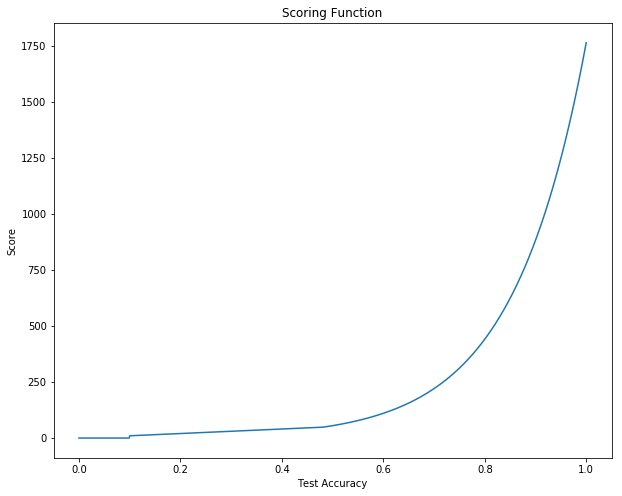

In [17]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.48, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')